# Regression - Classification

## Simple logistic regression

Examples are taken from [Handbook of Biological Statistics](http://www.biostathandbook.com/simplelogistic.html) chapter on simple logistic regression.

In [1]:
# imports
import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import scipy.special
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
sns.set()

The lecture follows the `Spider` data from *Suzuki et al. (2006)*:

In [2]:
raw_data = """Grain size (mm)	Spiders
0.245	absent
0.247	absent
0.285	present
0.299	present
0.327	present
0.347	present
0.356	absent
0.36	present
0.363	absent
0.364	present
0.398	absent
0.4	present
0.409	absent
0.421	present
0.432	absent
0.473	present
0.509	present
0.529	present
0.561	absent
0.569	absent
0.594	present
0.638	present
0.656	present
0.816	present
0.853	present
0.938	present
1.036	present
1.045	present
"""
df = pd.read_table(io.StringIO(raw_data))
df.Spiders = (df.Spiders == 'present').astype(int)
df.sample(8)

,Grain size (mm),Spiders
0,0.245,0
27,1.045,1
20,0.594,1
22,0.656,1
2,0.285,1
7,0.360,1
6,0.356,0
9,0.364,1


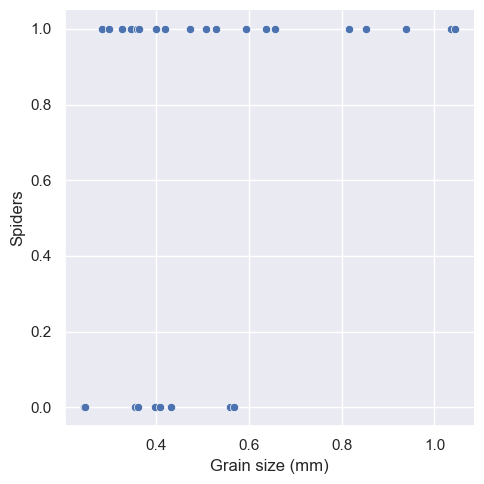

In [3]:
sns.relplot(x='Grain size (mm)',y='Spiders', data=df);

## Linear Probability Model

Applying linear regression directly to this leads to the **linear Probability Model**, where the probability of $y = 1$ is linear.

This can lead to some probabilities below 0 or above 1:

In [4]:
y = df['Spiders']
X = df['Grain size (mm)']
X = sm.add_constant(X)

est = sm.OLS(y,X).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Spiders   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     8.884
Date:                Sun, 11 Dec 2022   Prob (F-statistic):            0.00617
Time:                        10:03:00   Log-Likelihood:                -16.457
No. Observations:                  28   AIC:                             36.91
Df Residuals:                      26   BIC:                             39.58
Df Model:                           1                                         
Covariance Type:                  HC2                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2945      0.196      1.502      0.133      -0.090       0.679
Grain size (mm)     0.7432      0.249      2.981      0.003       0.254       1.232
==============================================================================
Omnibus:                       12.199   Durbin-Watson:                   2.446
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                3.394
Skew:                          -0.470   Prob(JB):                        0.183
Kurtosis:                       1.576   Cond. No.                         5.63
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

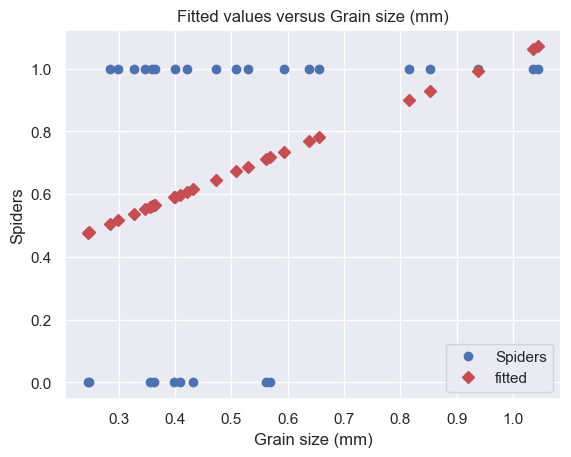

In [5]:
sm.graphics.plot_fit(est, 'Grain size (mm)', vlines=False);

## Logistic Regression

More desirable would be a model that fits to the probability space exactly.

Specifically, we want the output to be a [cumulative distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function) so it looks like a [sigmoid curve](https://en.wikipedia.org/wiki/Sigmoid_function)

**Logistic Regression** is a specialized model for when $y \in {0, 1}$, that is we have a binary target variable.

We have the odds $p$ that $y=1$ equal to 

$$log \dfrac{p}{1-p} = \beta \cdot X$$

The output is almost exactly the same shape as the CDF of the normal distribution in the Probit model, but is much easier to compute, so is used much more widely in practice, especially on huge datasets.

We can estimate the model using **Logistic Regression** in statsmodels:

In [6]:
# logistic regression
y = df['Spiders']
X = df['Grain size (mm)']
X = sm.add_constant(X)

logit_est = sm.Logit(y,X).fit(cov_type='HC2')
logit_est.summary()


Optimization terminated successfully.
         Current function value: 0.546992
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Spiders   No. Observations:                   28
Model:                          Logit   Df Residuals:                       26
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:                  0.1289
Time:                        10:03:00   Log-Likelihood:                -15.316
converged:                       True   LL-Null:                       -17.582
Covariance Type:                  HC2   LLR p-value:                   0.03324
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.6476      1.084     -1.520      0.128      -3.772       0.476
Grain size (mm)     5.1216      2.222      2.305      0.021       0.767       9.476
===================================================================================
"""

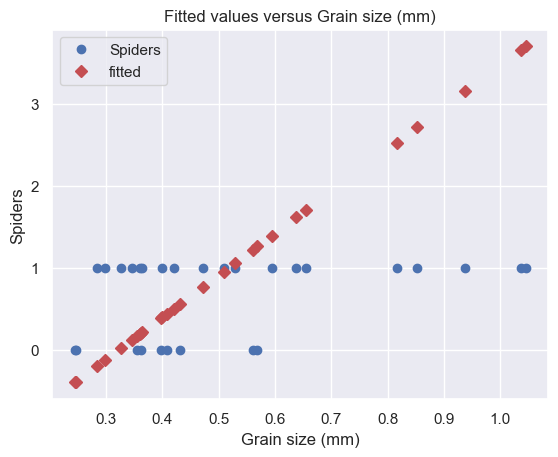

In [7]:
sm.graphics.plot_fit(logit_est, 'Grain size (mm)', vlines=False);

## SKLearn version

For purely predictive models, scikit-learn has a logisitic regression classifier which uses regularization. To eliminate regularization, we set the regularization parameter `C` very high.

In [8]:
# C=1e12 is effectively no regularization 1e8 also works in this case. 
# Just large numbers - see https://github.com/scikit-learn/scikit-learn/issues/6738

from sklearn.linear_model import LogisticRegression

X = df[['Grain size (mm)']] #Double brackets, not single 
y = df['Spiders']

model = LogisticRegression(C=1e8,random_state=0)
model.fit(X,y)

print('Coefficients: ', model.intercept_, model.coef_)

Coefficients:  [-1.64761944] [[5.12153671]]


In [9]:
def plot_log_reg(x, y, data, clf, xmin=None, xmax=None, alpha=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.scatter(data[x], data[y], color='black', zorder=20, alpha=alpha)
    if xmin is None:
        xmin = x.min()
    if xmax is None:
        xmax = x.max()
    X_test = np.linspace(xmin, xmax, 300)

    loss = scipy.special.expit(X_test * clf.coef_ + clf.intercept_).ravel()
    ax.plot(X_test, loss, linewidth=3)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fig.tight_layout()
    sns.despine()
    return fig, ax

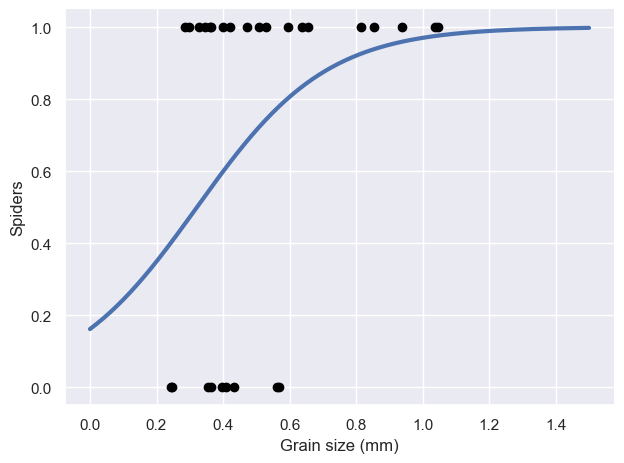

In [10]:
#
plot_log_reg(x='Grain size (mm)', y='Spiders', data=df, clf=model, xmin=0, xmax=1.5);

## Predictive modelling

It's common in predictive modelling to split your dataset in "train" and "test" sets, to make sure you don't overfit.

Note the difference between sklearn and statsmodels: sklearn outputs the actual predicted class, while statsmodels outputs the predicted probability when predicting. You can always get the probability in sklearn with `predict_proba()`.

Let's do a round of this on the **Titanic Dataset**.

In [11]:
df = sns.load_dataset('titanic')
df.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
852,0,3,female,9.0,1,1,15.2458,C,Third,child,False,NaN,Cherbourg,no,False
146,1,3,male,27.0,0,0,7.7958,S,Third,man,True,NaN,Southampton,yes,True
447,1,1,male,34.0,0,0,26.5500,S,First,man,True,NaN,Southampton,yes,True
635,1,2,female,28.0,0,0,13.0000,S,Second,woman,False,NaN,Southampton,yes,True
487,0,1,male,58.0,0,0,29.7000,C,First,man,True,B,Cherbourg,no,True


In [12]:
# predictive modelling

df = sns.load_dataset('titanic')

df['class'] = df['class'].astype(str)
df['deck'] = df['deck'].astype(str)

num_cols = ['age', 'fare'] 
cat_cols = ['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alone'] #categorical

df = df.dropna(axis=0, subset=num_cols) 

y = df.survived
X = df[['age','fare']].copy() #Don't want to affect our original DF

X['age2'] = X.age ** 2
X['fare2'] = X.fare ** 2

for col in cat_cols:
    X = X.join(pd.get_dummies(df[col],drop_first=True, prefix=col)) # Automate get dummies for each categorical col

X

,age,fare,age2,fare2,sex_male,embarked_Q,embarked_S,class_Second,class_Third,who_man,...,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embark_town_Queenstown,embark_town_Southampton,alone_True
0,22.0,7.2500,484.0,52.562500,1,0,1,0,1,1,...,0,0,0,0,0,0,1,0,1,0
1,38.0,71.2833,1444.0,5081.308859,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,26.0,7.9250,676.0,62.805625,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,1,1
3,35.0,53.1000,1225.0,2819.610000,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,35.0,8.0500,1225.0,64.802500,1,0,1,0,1,1,...,0,0,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,39.0,29.1250,1521.0,848.265625,0,1,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
886,27.0,13.0000,729.0,169.000000,1,0,1,1,0,1,...,0,0,0,0,0,0,1,0,1,1
887,19.0,30.0000,361.0,900.000000,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,1
889,26.0,30.0000,676.0,900.000000,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1


In [13]:
# predictive modelling continued .
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\Simona\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [14]:
# predictive modelling continued ..

y_pred = logreg.predict(X_test) #Predict on the test not train!
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test))) #Percentage

Accuracy of logistic regression classifier on test set: 0.79


## Interpretation of Prediction

### 1. Confusion Matrix

- Confusion Matrix is a matrix of true/false positive/negative predictions.
- You want more entries on the main diagonal, and fewer off the main diagonal.

In [15]:
# confusion matrix

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[110  15]
 [ 31  59]]


### 2. Precision

- The **precision** is the ratio `tp / (tp + fp)` where tp is the number of true positives and fp the number of false positives. 

- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

### 3. Recall

- The **recall** is the ratio `tp / (tp + fn)` where tp is the number of true positives and fn the number of false negatives. 
- The recall is intuitively the ability of the classifier to find all the positive samples.

### 4. F-Beta

- The **F-beta** score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
- The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

### 5. Support

- The **support** is the number of occurrences of each class in `y_true`.

In [16]:
# support
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred)) #Unlike most metrics, this one HAS to be printed for formatting 

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       125
           1       0.80      0.66      0.72        90

    accuracy                           0.79       215
   macro avg       0.79      0.77      0.77       215
weighted avg       0.79      0.79      0.78       215



## ROC Curve

The [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) plots the True and False positive rate across the test dataset. You want more AUC above the redline (which is effectively a random prediction)

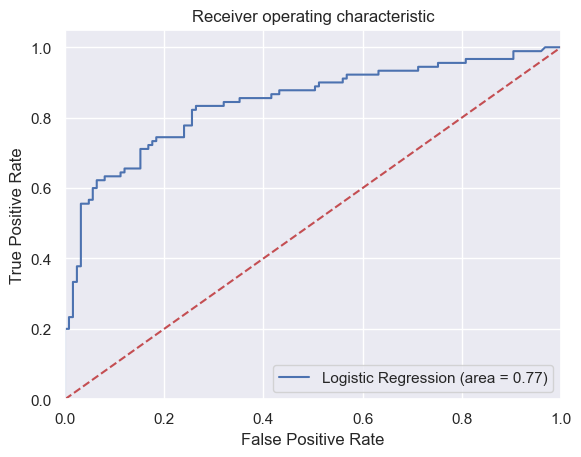

In [17]:
# roc curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

C:\Users\Simona\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


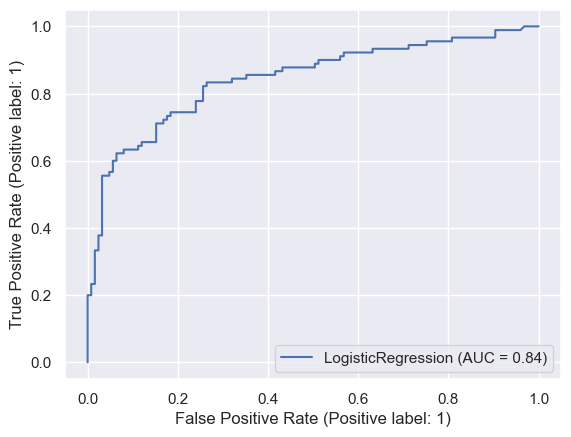

In [18]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(logreg,X_test,y_test);